In [23]:
import os
import csv
import pandas as pd
import numpy as np

import datetime
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import squarify

from sklearn import model_selection, preprocessing, metrics
plt.style.use('fivethirtyeight')

print(os.getcwd())
print(os.listdir("../input/"))

/kaggle/working
['acm.csv']


In [24]:
#load dataframe from csv
df = pd.read_csv("../input/acm.csv")

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2385066 entries, 0 to 2385065
Data columns (total 7 columns):
PaperTitle           object
Authors              object
Year                 float64
Publication_Venue    object
Index_Id             int64
References_Id        object
Abstract             object
dtypes: float64(1), int64(1), object(5)
memory usage: 127.4+ MB


In [26]:
df.shape

(2385066, 7)

In [27]:
df[df["Index_Id"] == 289023]

,PaperTitle,Authors,Year,Publication_Venue,Index_Id,References_Id,Abstract
289022,Shifting Graphs and Their Applications,"Nicholas Pippenger, Leslie G. Valiant",1976.0,Journal of the ACM (JACM),289023,:252607:288548:289037:289188:599901:600048:669...,Graphs that in a certain precise sense are ric...


***count_reference*** represents the number of times particular paper got referred in our dataset

In [28]:
df["count_reference"] = 0

In [29]:
df.isna().sum()

PaperTitle                46
Authors               151075
Year                    8428
Publication_Venue        139
Index_Id                   0
References_Id        1344739
Abstract              713788
count_reference            0
dtype: int64

In [30]:
df = df.dropna(axis=0,how='any')

In [31]:
df.isna().sum()

PaperTitle           0
Authors              0
Year                 0
Publication_Venue    0
Index_Id             0
References_Id        0
Abstract             0
count_reference      0
dtype: int64

In [32]:
df.shape

(977377, 8)

In [ ]:
df["Authors"].value_counts()

In [33]:
temp_df = df.loc[df['Authors'].astype(str).str.startswith('-')]

In [34]:
temp_df.shape

(1144, 8)

In [35]:
df = df.drop(df[df['Authors'].astype(str).str.startswith('-')].index)

In [36]:
df.shape

(976233, 8)

####YEAR

In [37]:
df["Year"] = df["Year"].fillna(0)
df["Year"] = df["Year"].astype(int)

**Rows with NaN year**

In [38]:
df[df["Year"] == 0]

,PaperTitle,Authors,Year,Publication_Venue,Index_Id,References_Id,Abstract,count_reference


***Year of publication distribution in the data***

In [ ]:
ydf = df[df["Year"]!=0]
plt.figure(figsize=(8,6))
plt.scatter(range(ydf.shape[0]), np.sort(ydf["Year"].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Year', fontsize=12)
plt.title("Year Distribution", fontsize=20) 
plt.show()

In [ ]:
df.isna().sum()

In [ ]:
print(df.dtypes)

In [39]:
df["Index_Id"].unique()
print(any(df['Index_Id'].duplicated())) 
print(len(df['Index_Id'].unique()))
print(len(df.index))

False
976233
976233


> Index_Id = 2381731 is duplicated 9 times , It points to 7 different papers and has 82080 references.

In [40]:
df[df.duplicated(subset="Index_Id")]

,PaperTitle,Authors,Year,Publication_Venue,Index_Id,References_Id,Abstract,count_reference


In [41]:
reference_count = {}
for references in df[df["References_Id"].notnull()]["References_Id"]:
    ref_list = map(int,references.strip(":").split(":"))
    for ref in ref_list:
        if ref in reference_count:
            reference_count[ref] += 1
        else:
            reference_count[ref] = 1
print(reference_count[2381731])

76236


In [42]:
def update_ref_count(row):
    if row['Index_Id'] in reference_count:
        return reference_count[row['Index_Id']]
    else:
        return 0
df["count_reference"] = df.apply(lambda row: update_ref_count(row),axis=1)

In [43]:
print(df.head(5))

                                            PaperTitle       ...       count_reference
117                     Algorithms for trie compaction       ...                    12
133  Logical, internal, and physical reference beha...       ...                     9
134    A parallel pipelined relational query processor       ...                     8
147           Practical data-swapping: the first steps       ...                    38
149  An extension of conflict-free multivalued depe...       ...                     3

[5 rows x 8 columns]


In [44]:
sorted_by_value = sorted(reference_count.items(), key=lambda kv: kv[1],reverse=True)
print(sorted_by_value[:10])
print([row[0] for row in sorted_by_value[:10]])
print([row[1] for row in sorted_by_value[:10]])

[(2135000, 884601), (2381731, 76236), (408395, 8038), (369235, 6269), (190580, 5233), (136349, 4726), (729436, 4439), (168250, 4413), (760804, 4147), (115607, 3360)]
[2135000, 2381731, 408395, 369235, 190580, 136349, 729436, 168250, 760804, 115607]
[884601, 76236, 8038, 6269, 5233, 4726, 4439, 4413, 4147, 3360]


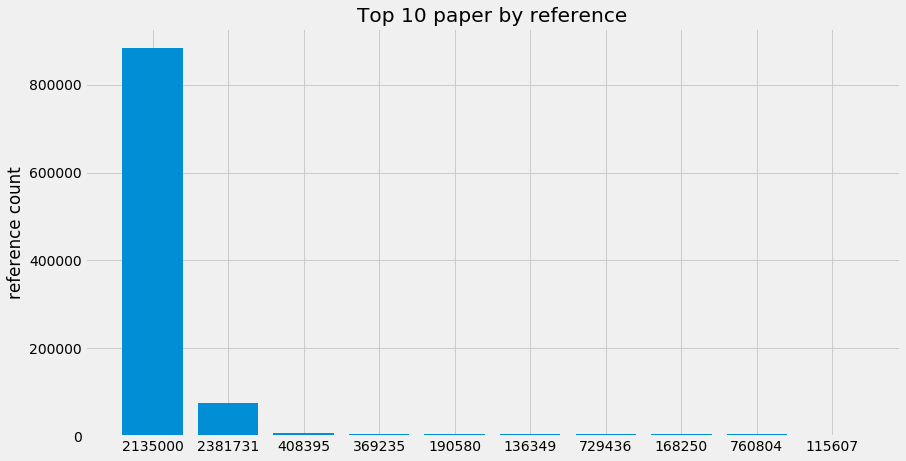

In [45]:
x_values = [row[0] for row in sorted_by_value[:10]]
y_values = [row[1] for row in sorted_by_value[:10]]
x_pos = np.arange(len(x_values))
plt.figure(figsize=(13,7))
plt.bar(x_pos,y_values, align='center', alpha=1)
plt.xticks(x_pos,x_values)
plt.ylabel('reference count')
plt.title('Top 10 paper by reference')
 
plt.show()

In [46]:
print(df.shape)
df.isna().sum()

(976233, 8)


PaperTitle           0
Authors              0
Year                 0
Publication_Venue    0
Index_Id             0
References_Id        0
Abstract             0
count_reference      0
dtype: int64

In [58]:
del reference_count
outlink_map = {}
inlink_map = {}
df_new = df[df["References_Id"].notnull()]
for index, row in df_new.iterrows():
    ref = row["References_Id"]
    ref_list = list(map(int,ref.strip(":").split(":")))
    outlink_map[row["Index_Id"]] = ref_list
    for ref in ref_list:
        listi = inlink_map.get(ref, [])
        listi.append(row["Index_Id"])
        inlink_map[ref] = listi

In [55]:
def calculate_page_rank():
    count = 0
    page_rank = {}
    updated_page_rank = {}
    for index in df["Index_Id"]:
        page_rank[index] = 1
    while True:
        count += 1
        flag = True
        for key in page_rank:
            cs = page_rank[key]
            if key in inlink_map:
                inlink_list = inlink_map[key]
                ns = 0
                for link in inlink_list:
                    if link in page_rank and link in outlink_map:
                        ns += page_rank[link]/len(outlink_map[link])
                ns = 0.15 + (0.85 * ns)
                if cs != ns:
                    flag = False
                updated_page_rank[key] = ns
        if flag == True:
            print(count)
            break
        page_rank = updated_page_rank
        updated_page_rank = {}
        return page_rank

In [59]:
page_rank = calculate_page_rank()
del outlink_map
del inlink_map

In [60]:
page_rank

{118: 0.4619725025273099,
 134: 0.6668174603174604,
 135: 0.6684372571872572,
 148: 1.804704247829138,
 150: 0.2909775007601094,
 316: 1.391871323121323,
 318: 1.109459719268279,
 319: 11.127667456800163,
 320: 0.5969071468182766,
 321: 2.223928628579658,
 322: 1.0092757936507935,
 326: 1.5259769421611524,
 470: 1.6107625116818662,
 506: 0.5060265429015429,
 511: 1.221510744372586,
 549: 0.2430603448275862,
 553: 2.968660714198197,
 554: 2.0874040114754564,
 712: 1.585983282548826,
 713: 0.9656431644756233,
 734: 4.776552233947157,
 781: 7.941193578322673,
 838: 4.079142379151288,
 868: 0.2952991452991453,
 869: 3.38982927147342,
 871: 4.422385183356071,
 973: 0.3139500442086649,
 974: 1.18442327817391,
 975: 2.870634303525408,
 976: 0.39348684210526313,
 1011: 39.63384244448198,
 1014: 7.008519950117533,
 1015: 0.9333530418856506,
 1016: 0.9486275473792667,
 1017: 15.492633112529742,
 1018: 4.510163619763203,
 1020: 23.72413974578362,
 1021: 6.873755606204745,
 1022: 1.983577480633401

In [61]:
df["page_rank"] = 0

In [62]:
def update_rank(row):
    if row["Index_Id"] in page_rank:
        return page_rank[row["Index_Id"]]
    else:
        return 0

In [63]:
df["page_rank"] = df.apply(lambda row: update_rank(row),axis = 1)

In [64]:
df["page_rank"][0:10]

117     0.461973
133     0.666817
134     0.668437
147     1.804704
149     0.290978
315     1.391871
316     0.000000
317     1.109460
318    11.127667
319     0.596907
Name: page_rank, dtype: float64

In [65]:
df.head(5)

,PaperTitle,Authors,Year,Publication_Venue,Index_Id,References_Id,Abstract,count_reference,page_rank
117,Algorithms for trie compaction,"M. Al-Suwaiyel, E Horowitz",1984,ACM Transactions on Database Systems (TODS),118,:1157:252607:287497:289080:408503:326292:32687...,The trie data structure has many properties wh...,12,0.461973
133,"Logical, internal, and physical reference beha...","Wolfgang Effelsberg, Mary E. S. Loomis",1984,ACM Transactions on Database Systems (TODS),134,:286819:287482:287680:287739:287766:287646:317...,This work investigates one aspect of the perfo...,9,0.666817
134,A parallel pipelined relational query processor,"Won Kim, Daniel Gajski, David J. Kuck",1984,ACM Transactions on Database Systems (TODS),135,:287004:287293:287666:287494:317954:321467:322...,This paper presents the design of a relational...,8,0.668437
147,Practical data-swapping: the first steps,Steven P. Reiss,1984,ACM Transactions on Database Systems (TODS),148,:287296:287297:289164:649353:2135000,The problem of statistical database confidenti...,38,1.804704
149,An extension of conflict-free multivalued depe...,Hirofumi Katsuno,1984,ACM Transactions on Database Systems (TODS),150,:287338:287676:289281:289349:289304:289423:374...,"Several researchers (Beeri, Bernstein, Chiu, F...",3,0.290978


In [66]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_vals = list(df["Publication_Venue"].values.astype(str))
le.fit(train_vals)
df["Publication_Venue"] = le.transform(train_vals)

In [67]:
df.head(5)

,PaperTitle,Authors,Year,Publication_Venue,Index_Id,References_Id,Abstract,count_reference,page_rank
117,Algorithms for trie compaction,"M. Al-Suwaiyel, E Horowitz",1984,637,118,:1157:252607:287497:289080:408503:326292:32687...,The trie data structure has many properties wh...,12,0.461973
133,"Logical, internal, and physical reference beha...","Wolfgang Effelsberg, Mary E. S. Loomis",1984,637,134,:286819:287482:287680:287739:287766:287646:317...,This work investigates one aspect of the perfo...,9,0.666817
134,A parallel pipelined relational query processor,"Won Kim, Daniel Gajski, David J. Kuck",1984,637,135,:287004:287293:287666:287494:317954:321467:322...,This paper presents the design of a relational...,8,0.668437
147,Practical data-swapping: the first steps,Steven P. Reiss,1984,637,148,:287296:287297:289164:649353:2135000,The problem of statistical database confidenti...,38,1.804704
149,An extension of conflict-free multivalued depe...,Hirofumi Katsuno,1984,637,150,:287338:287676:289281:289349:289304:289423:374...,"Several researchers (Beeri, Bernstein, Chiu, F...",3,0.290978


In [ ]:
df["Number Of Authors"] = 0

In [70]:
def cal_authors(authors):
    author_list = authors.split(",")
    return len(author_list)

In [71]:
df["Number Of Authors"] = df["Authors"].apply(lambda val:cal_authors(val))

In [72]:
df.head(5)

,PaperTitle,Authors,Year,Publication_Venue,Index_Id,References_Id,Abstract,count_reference,page_rank,Number Of Authors
117,Algorithms for trie compaction,"M. Al-Suwaiyel, E Horowitz",1984,637,118,:1157:252607:287497:289080:408503:326292:32687...,The trie data structure has many properties wh...,12,0.461973,2
133,"Logical, internal, and physical reference beha...","Wolfgang Effelsberg, Mary E. S. Loomis",1984,637,134,:286819:287482:287680:287739:287766:287646:317...,This work investigates one aspect of the perfo...,9,0.666817,2
134,A parallel pipelined relational query processor,"Won Kim, Daniel Gajski, David J. Kuck",1984,637,135,:287004:287293:287666:287494:317954:321467:322...,This paper presents the design of a relational...,8,0.668437,3
147,Practical data-swapping: the first steps,Steven P. Reiss,1984,637,148,:287296:287297:289164:649353:2135000,The problem of statistical database confidenti...,38,1.804704,1
149,An extension of conflict-free multivalued depe...,Hirofumi Katsuno,1984,637,150,:287338:287676:289281:289349:289304:289423:374...,"Several researchers (Beeri, Bernstein, Chiu, F...",3,0.290978,1


In [74]:
df["Number Of Authors"].value_counts()

2      299722
3      257046
1      154673
4      145068
5       64730
6       28854
7       12060
8        6066
9        3074
10       1731
11       1039
12        631
13        422
14        312
15        190
16        124
17        102
18         88
19         45
20         43
21         37
22         30
24         21
23         20
26         16
27         14
25         14
29          9
28          8
30          6
31          6
33          3
37          3
38          2
83          2
45          2
42          2
39          2
34          2
32          2
110         1
41          1
36          1
43          1
46          1
50          1
52          1
59          1
63          1
65          1
77          1
115         1
Name: Number Of Authors, dtype: int64

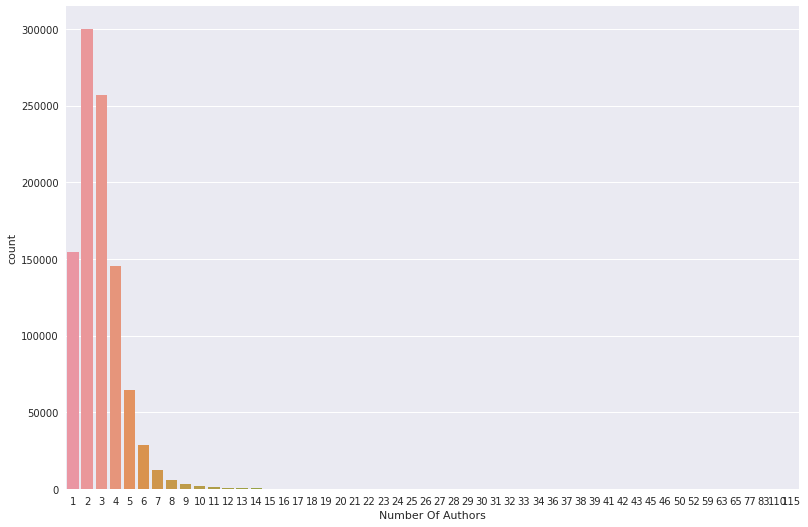

In [92]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="darkgrid")
ax = sns.countplot(x="Number Of Authors", data=df)

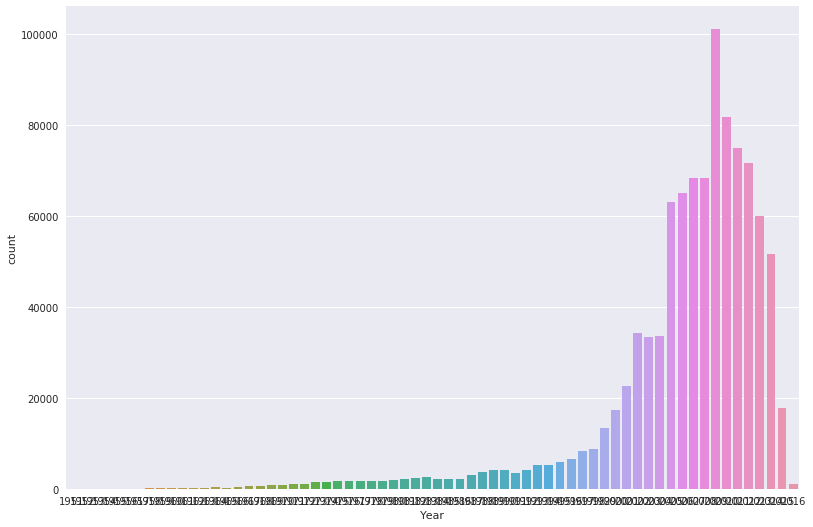

In [76]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="darkgrid")
ax = sns.countplot(x="Year", data=df)

In [79]:
outlink = {}
inlink = {}
df_new = df[df["References_Id"].notnull()]
for index, row in df_new.iterrows():
    ref = row["References_Id"]
    ref_list = list(map(int,ref.strip(":").split(":")))
    outlink[row["Index_Id"]] = ref_list
    for ref in ref_list:
        listi = inlink.get(ref, [])
        listi.append(row["Index_Id"])
        inlink[ref] = listi
page_year = {row["Index_Id"]:row["Year"] for _t, row in df.iterrows()}
year_citation_count = { page_year[index]:0 for index in page_year}
year_paper_count = { page_year[index]:0 for index in page_year}
avg_year_citation_count = {}
for index in page_year:
    year = page_year[index]
    len_outlink = len(outlink.get(index, []))
    if len_outlink > 0:
        year_citation_count[year] += len_outlink
        year_paper_count[year] += 1
for year in year_citation_count:
    if year_paper_count[year] > 0:
        avg_year_citation_count[year] = year_citation_count[year]/year_paper_count[year]

In [80]:
print(year_citation_count)

{1984: 11107, 1983: 12002, 1985: 10642, 1982: 10600, 1986: 12854, 1987: 19256, 1988: 24335, 1989: 28418, 2000: 160345, 1990: 30207, 1991: 25222, 1992: 33167, 1993: 39756, 1994: 47248, 1995: 49903, 2011: 799051, 1996: 57236, 1997: 74401, 1998: 82083, 1999: 127954, 1981: 10192, 1979: 6955, 1980: 8506, 1978: 7330, 1976: 7602, 1977: 7268, 1958: 126, 1959: 176, 1960: 229, 1961: 279, 1962: 289, 1964: 793, 1965: 630, 1966: 897, 1967: 1367, 1968: 1604, 1969: 2550, 1970: 2474, 1973: 4853, 1974: 4623, 1975: 6269, 1972: 3794, 1971: 3818, 2001: 207001, 1963: 452, 2002: 307035, 2009: 906223, 2003: 290130, 1952: 26, 2010: 844103, 1956: 59, 2004: 307012, 2005: 545633, 2006: 582258, 2007: 633840, 2008: 655603, 2013: 705861, 1951: 16, 1953: 6, 1954: 14, 1955: 24, 1957: 79, 2012: 829332, 2014: 586979, 2015: 91576, 2016: 2704}


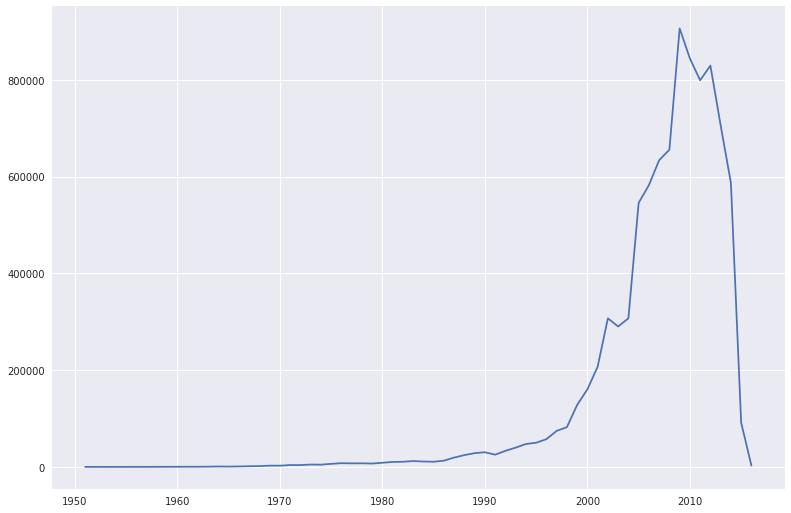

In [81]:
import matplotlib.pylab as plt
lists = sorted(year_citation_count.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x, y)
plt.show()

In [82]:
df.head(5)

,PaperTitle,Authors,Year,Publication_Venue,Index_Id,References_Id,Abstract,count_reference,page_rank,Number Of Authors
117,Algorithms for trie compaction,"M. Al-Suwaiyel, E Horowitz",1984,637,118,:1157:252607:287497:289080:408503:326292:32687...,The trie data structure has many properties wh...,12,0.461973,2
133,"Logical, internal, and physical reference beha...","Wolfgang Effelsberg, Mary E. S. Loomis",1984,637,134,:286819:287482:287680:287739:287766:287646:317...,This work investigates one aspect of the perfo...,9,0.666817,2
134,A parallel pipelined relational query processor,"Won Kim, Daniel Gajski, David J. Kuck",1984,637,135,:287004:287293:287666:287494:317954:321467:322...,This paper presents the design of a relational...,8,0.668437,3
147,Practical data-swapping: the first steps,Steven P. Reiss,1984,637,148,:287296:287297:289164:649353:2135000,The problem of statistical database confidenti...,38,1.804704,1
149,An extension of conflict-free multivalued depe...,Hirofumi Katsuno,1984,637,150,:287338:287676:289281:289349:289304:289423:374...,"Several researchers (Beeri, Bernstein, Chiu, F...",3,0.290978,1


In [88]:
num_columns= ["Year","Publication_Venue","Index_Id","count_reference","Number Of Authors"]
df_train = df[num_columns]

In [89]:
from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(df_train, df["page_rank"], test_size=0.25, random_state=20)

In [90]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(train_x,train_y)
print(reg.coef_)

[-3.62911094e-03 -1.62769248e-06 -1.63825850e-08  6.75956914e-02
  1.03957309e-03]


In [91]:
from sklearn import metrics
pred_y = reg.predict(valid_x)
rmse_initial = np.sqrt(metrics.mean_squared_error(pred_y,valid_y))
print(rmse_initial)

0.3407822953747882


In [ ]:
df.to_csv("ranked_acm_1.csv")